In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
class Node:
    def __init__(self, x, y, freex=True, freey=True):
        
        self.x = x
        self.y = y
        
        self.pos = np.array([x,y])
        
        self.freex = freex
        self.freey = freey
        
        self.dx = 0
        self.dy = 0
        
        self.fx = 0
        self.fy = 0
        
    def __eq__(self, other):
        # only checks for position, not for whether the boundarys are defined the same
        return np.allclose(self.pos,other.pos)

    def __hash__(self):
        return hash((self.x, self.y))
    
    def __repr__(self):
        return f'N({self.x:2.2f}, {self.y:2.2f})'
    
    def plot(self):
        if self.freex and self.freey:
            plt.plot(self.x, self.y,'ko')
        elif self.freex and not self.freey:
            plt.plot(self.x, self.y,'bo')
        elif not self.freex and self.freey:
            plt.plot(self.x, self.y,'go')
        else:
            plt.plot(self.x, self.y,'ro')
        
    def apply_load(self, fx, fy):
        # adds the load to the previous value
        self.fx += fx
        self.fy += fy
        
class Bar:
    def __init__(self, node0, node1, w=5e-3, t=6.35e-3, E=71e9):
        
        self.node0 = node0
        self.node1 = node1
        self.w = w
        self.t = t
        self.E = E
        
        # get bar length
        self.length = l = self._length(node0, node1)
        
        # define the angle of the bar
        self.theta = th = self._theta(node0, node1)
    
        # def e vector
        self.e = e = np.array([np.cos(th), np.sin(th)])
        
        self.eeT = eeT = np.outer(e, e)
        
        self.nom_stiff = (1/l)*np.block([[eeT, -eeT], [-eeT, eeT]])
        # note the actual stiffness matrix = nomStiff*(EA)
        
        # trim values smaller than 1e-12
        #self.nom_stiff = np.clip(self.nom_stiff, a_min = 1e-12,a_max=None)
    
    def __eq__(self, other):
        # only checks if the same nodes are used, not for material or thicknesses. 
        
        if (self.node0 == other.node0 and self.node1 == other.node1) or (self.node0 == other.node1 and self.node1 == other.node0):
            return True
        else:
            return False
        
    def __hash__(self):
        return hash((self.node0, self.node1))
    
    def __repr__(self):
        return f'B({self.node0}, {self.node1})'
    
    def plot(self):
        nodes = [self.node0, self.node1]
        
        x = [n.x for n in nodes]
        y = [n.y for n in nodes]
        
        xdx = [n.x+n.dx for n in nodes]
        ydy = [n.y+n.dy for n in nodes]
        
        plt.plot(x, y, 'b')
        plt.plot(xdx, ydy, 'b--')
        
    def EA(self):
        return self.E * self.w * self.t
    
    def _theta(self, n0, n1):
        """Get angle of vector from n0 to n1"""
        
        v = n1.pos - n0.pos
        
        return np.arctan2(v[1], v[0])
    
    def _length(self, n0, n1):
        """Get length of vector between n0 and n1"""
        
        v = n1.pos - n0.pos
        
        return np.sqrt(np.dot(v, v))
    
class Truss:
    def __init__(self, bars):
        
        """Class to define a truss"""
        
        self.bars = list(set(bars))
        
        # extract nodes
        self.nodes = nodes = self.extract_nodes(bars)
        
        self.defTruss = None
        
        
    def solve(self):
        # create stiffness matrix (we will delete the non-free nodes at the end)
        # for each node, assemble the stiffness matrix
        # 2*nodes because each node can have 2 degrees of freedom
        nodes = self.nodes
        bars = self.bars
        
        self.nom_stiff = nom_stiff = np.zeros([2*len(nodes), 2*len(nodes)])
        
        #print(f'Nodes: {nodes}')
        
        for bar in self.bars:
            #print(bar)
            # find the n0 index, n1 index
            n0ind = nodes.index(bar.node0)
            n1ind = nodes.index(bar.node1)
            
            
            # replace all 16 elements
            nom_stiff[2*n0ind:2*n0ind+2,2*n0ind:2*n0ind+2]+=bar.nom_stiff[0:2, 0:2]
            nom_stiff[2*n0ind:2*n0ind+2,2*n1ind:2*n1ind+2]+=bar.nom_stiff[0:2, 2:4]
            nom_stiff[2*n1ind:2*n1ind+2,2*n0ind:2*n0ind+2]+=bar.nom_stiff[2:4, 0:2]
            nom_stiff[2*n1ind:2*n1ind+2,2*n1ind:2*n1ind+2]+=bar.nom_stiff[2:4, 2:4]
            
        # create force vector
        
        self.F = np.zeros(2*len(self.nodes))
        for i, node in enumerate(self.nodes):
            self.F[2*i] = node.fx
            self.F[2*i+1] = node.fy
            
        # list the rows that are with fixed constraints
        delrows = []
        for i, node in enumerate(self.nodes):
            if node.freex == False:
                delrows.append(2*i)
            if node.freey == False:
                delrows.append(2*i+1)
                
        # delete rows from the stiffness matrix
        nom_stiff = np.delete(nom_stiff, delrows, axis=0)
        nom_stiff = np.delete(nom_stiff, delrows, axis=1)
        self.nom_stiff = nom_stiff
    
        # delete rows from the force vector
        self.F = np.delete(self.F, delrows)
        
        #compute the displaced structure
        sol = np.linalg.lstsq(truss.nom_stiff, truss.F)
        u = sol[0] # u is all the deflections of each beam
        
        
        # reconstruct deformations
        ind = 0
        for i,node in enumerate(self.nodes):
            if node.freex:
                node.dx = u[ind]
                ind += 1
            if node.freey:
                node.dy = u[ind]
                ind += 1
                
        # create deformed truss
        # create new bars from old bars
        defBar = []
        for bar in self.bars:
            defBar.append(Bar(bar.node0, bar.node1))
            
        # create truss
        self.defTruss = Truss(defBar)
        
        return self.defTruss
    
    
            
    def plot(self):
        
        #plot all bars
        for bar in self.bars:
            bar.plot()
        for node in self.nodes:
            node.plot()
            
        
        
    def extract_nodes(self,bars):
        
        nodes = set()
        
        for bar in bars:
            nodes.add(bar.node0)
            nodes.add(bar.node1)
            
        return list(nodes)
        

In [50]:
n0 = Node(0,0, freex=False,freey=False)
n1 = Node(1,0, freey=False)
n2 = Node(0,1)
n3 = Node(1,1)

n3.apply_load(0, 0.3)

In [51]:
b0 = Bar(n0,n1)
b1 = Bar(n0,n2)
b2 = Bar(n0,n3)
b3 = Bar(n1,n2)
b4 = Bar(n1,n3)
b5 = Bar(n2,n3)

In [52]:
with np.printoptions(precision=3, suppress=True):
    truss = Truss([b0,b1,b2,b3,b4,b5])
    defTruss=truss.solve()
    print(truss.nom_stiff)
    print(truss.F)

[[ 1.354 -0.354 -0.354 -1.     0.   ]
 [-0.354  1.354  0.354  0.     0.   ]
 [-0.354  0.354  1.354 -0.    -0.   ]
 [-1.     0.    -0.     1.354  0.354]
 [ 0.     0.    -0.     0.354  1.354]]
[0.  0.  0.  0.  0.3]


/Users/Devansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [53]:
truss.nodes

[N(0.00, 1.00), N(1.00, 0.00), N(0.00, 0.00), N(1.00, 1.00)]

In [54]:
truss.u

array([-0.15      , -0.03106602, -0.03106602, -0.18106602,  0.26893398])

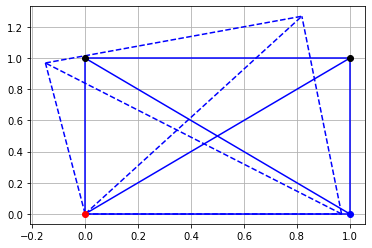

In [55]:
defTruss.plot()
plt.grid()

In [7]:
truss.nom_stiff.transpose()

array([[ 1.35355339e+00, -3.53553391e-01, -3.53553391e-01,
        -6.12323400e-17, -1.00000000e+00,  0.00000000e+00],
       [-3.53553391e-01,  1.35355339e+00,  3.53553391e-01,
        -1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.53553391e-01,  3.53553391e-01,  1.35355339e+00,
         0.00000000e+00, -3.74939946e-33, -6.12323400e-17],
       [-6.12323400e-17, -1.00000000e+00,  0.00000000e+00,
         1.35355339e+00, -3.53553391e-01, -3.53553391e-01],
       [-1.00000000e+00,  0.00000000e+00, -3.74939946e-33,
        -3.53553391e-01,  1.35355339e+00,  3.53553391e-01],
       [ 0.00000000e+00,  0.00000000e+00, -6.12323400e-17,
        -3.53553391e-01,  3.53553391e-01,  1.35355339e+00]])

In [8]:
sol=np.linalg.solve(truss.nom_stiff, truss.F)

In [9]:
sol

array([ 2.70215978e+16,  2.70215978e+16, -1.65685425e+00,  2.70215978e+16,
        2.70215978e+16,  0.00000000e+00])

In [10]:
sol = np.linalg.lstsq(truss.nom_stiff, truss.F)
sol[0]

/Users/Devansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([-0.59466991,  0.59466991, -0.31066017,  0.90533009, -0.90533009,
        2.68933983])

In [11]:
sol

(array([-0.59466991,  0.59466991, -0.31066017,  0.90533009, -0.90533009,
         2.68933983]),
 array([], dtype=float64),
 5,
 array([2.87177331e+00, 2.00000000e+00, 1.62570669e+00, 1.18888686e+00,
        4.34953478e-01, 3.95030112e-17]))

In [12]:
truss.nodes

[N(0.00, 1.00), N(1.00, 0.00), N(0.00, 0.00), N(1.00, 1.00)]

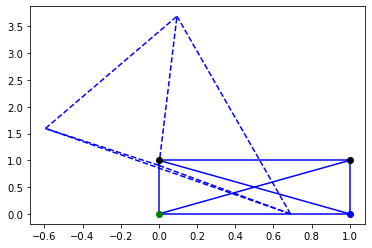

In [13]:
truss.plot()

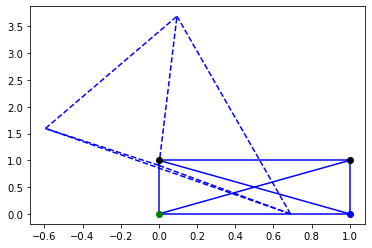

In [14]:
truss.plot()

In [15]:
n0.__dict__

{'x': 0,
 'y': 0,
 'pos': array([0, 0]),
 'freex': False,
 'freey': True,
 'dx': 0,
 'dy': 0.9053300858899105,
 'fx': 0,
 'fy': 0}

In [16]:
n0ind=0
n1ind=2

In [17]:
with np.printoptions(precision=3, suppress=True):
    print(truss.nom_stiff)

[[ 1.354 -0.354 -0.354 -0.    -1.     0.   ]
 [-0.354  1.354  0.354 -1.     0.     0.   ]
 [-0.354  0.354  1.354  0.    -0.    -0.   ]
 [-0.    -1.     0.     1.354 -0.354 -0.354]
 [-1.     0.    -0.    -0.354  1.354  0.354]
 [ 0.     0.    -0.    -0.354  0.354  1.354]]


In [18]:
n = len(truss.nodes)
A = 1.0*np.random.randint(low=0, high=10, size=(2*n, 2*n))

In [19]:
A

array([[3., 6., 4., 0., 1., 9., 6., 2.],
       [4., 2., 3., 8., 9., 8., 0., 2.],
       [2., 2., 2., 9., 7., 0., 6., 4.],
       [7., 9., 4., 8., 4., 5., 9., 5.],
       [3., 9., 5., 5., 0., 9., 6., 2.],
       [2., 9., 9., 5., 0., 5., 8., 5.],
       [7., 1., 3., 1., 1., 5., 0., 4.],
       [0., 1., 4., 5., 9., 7., 0., 9.]])

In [20]:
A[n0ind:n0ind+2,n1ind:n1ind+2]+=b0.nom_stiff[0:2, 0:2]

In [21]:
b0.nom_stiff

array([[ 1.,  0., -1., -0.],
       [ 0.,  0., -0., -0.],
       [-1., -0.,  1.,  0.],
       [-0., -0.,  0.,  0.]])

In [22]:
A

array([[3., 6., 5., 0., 1., 9., 6., 2.],
       [4., 2., 3., 8., 9., 8., 0., 2.],
       [2., 2., 2., 9., 7., 0., 6., 4.],
       [7., 9., 4., 8., 4., 5., 9., 5.],
       [3., 9., 5., 5., 0., 9., 6., 2.],
       [2., 9., 9., 5., 0., 5., 8., 5.],
       [7., 1., 3., 1., 1., 5., 0., 4.],
       [0., 1., 4., 5., 9., 7., 0., 9.]])

In [23]:
b3.nom_stiff

array([[ 0.35355339, -0.35355339, -0.35355339,  0.35355339],
       [-0.35355339,  0.35355339,  0.35355339, -0.35355339],
       [-0.35355339,  0.35355339,  0.35355339, -0.35355339],
       [ 0.35355339, -0.35355339, -0.35355339,  0.35355339]])

In [24]:
b3.nom_stiff[0:2, 2:4]

array([[-0.35355339,  0.35355339],
       [ 0.35355339, -0.35355339]])

In [58]:
import scipy as sp

points = np.array([[n.x, n.y] for n in [n0, n1, n2, n3]])

d=sp.spatial.Delaunay(points)

In [60]:
d.neighbors

array([[-1,  1, -1],
       [ 0, -1, -1]], dtype=int32)

In [62]:
d.simplices

array([[3, 2, 0],
       [1, 3, 0]], dtype=int32)

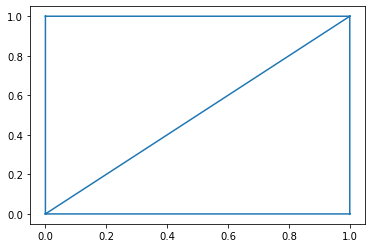

In [64]:
plt.triplot(points[:,0], points[:,1], d.simplices.copy())

In [67]:
find_neighbors(0, d)

[1, 2, 3]

In [68]:
find_neighbors(1, d)

[0, 3]

In [69]:
nodes = [Node(np.random.rand(), np.random.rand()) for n in range(10)]

[None, None, None, None, None, None, None, None, None, None]

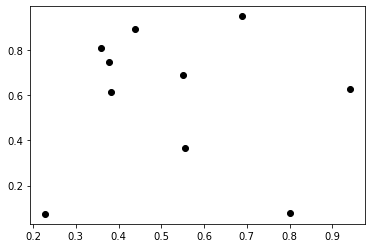

In [72]:
[n.plot() for n in nodes]

In [73]:
node_points = np.array([[n.x, n.y] for n in nodes])

In [75]:
d = sp.spatial.Delaunay(node_points)

In [76]:
d

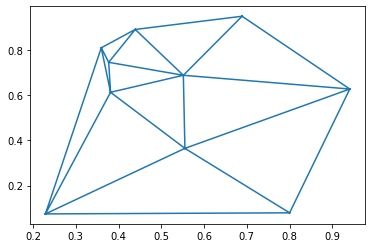

In [77]:
plt.triplot(node_points[:,0], node_points[:,1], d.simplices.copy())

In [78]:
find_neighbors(0, d)

[9, 4, 5, 7]

In [107]:
# function to find the neighbors of a node
find_neighbors = lambda x,triang: list(set(indx for simplex in triang.simplices if x in simplex for indx in simplex if indx !=x))

def create_delaunay_Truss(nodes):
    
    # create numpy nodes array
    node_points = np.array([[n.x, n.y] for n in nodes])

    # perform the triangulation
    d = sp.spatial.Delaunay(node_points)
    
    bars = []
    
    for i, node in enumerate(nodes):
        
        neighbors = find_neighbors(i, d)
        for n in neighbors:
            #print(i, n)
            #b = Bar(node, nodes[n])
            #print(b)
            #bars.append(b)
        bars.extend([Bar(node, nodes[n]) for n in neighbors])

    return Truss(bars)
    

[[0.35943616 0.8087459 ]
 [0.94079412 0.62657453]
 [0.7999938  0.07955648]
 [0.5550887  0.36441583]
 [0.22878639 0.07473198]
 [0.38114382 0.6121628 ]
 [0.6889194  0.94817664]
 [0.43887816 0.88978575]
 [0.55146314 0.68734474]
 [0.37682729 0.74463437]]
0 9
0 4
0 5
0 7
1 8
1 2
1 3
1 6
2 1
2 3
2 4
3 1
3 2
3 4
3 5
3 8
4 0
4 2
4 3
4 5
5 0
5 3
5 4
5 8
5 9
6 8
6 1
6 7
7 8
7 9
7 6
7 0
8 1
8 3
8 5
8 6
8 7
8 9
9 8
9 0
9 5
9 7


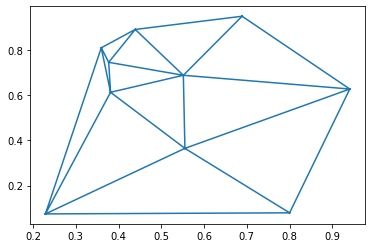

In [109]:
bars = create_delaunay_bars(nodes)

In [110]:
t=Truss(bars)

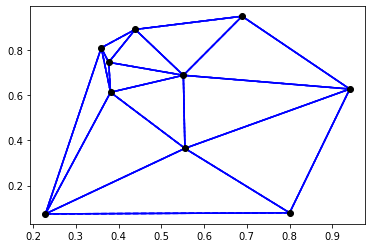

In [111]:
t.plot()